In [1]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install GPy
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'

In [2]:
torch.cuda.device(0)
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla T4'

In [0]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [0]:
class Langevin_SGD(Optimizer):

    def __init__(self, params, lr, weight_decay=0, nesterov=False):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, weight_decay=weight_decay)
        
        super(Langevin_SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            
            weight_decay = group['weight_decay']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                if len(p.shape) == 1 and p.shape[0] == 1:
                    p.data.add_(-group['lr'], d_p)
                    
                else:
                    if weight_decay != 0:
                        d_p.add_(weight_decay, p.data)

                    unit_noise = Variable(p.data.new(p.size()).normal_())

                    p.data.add_(-group['lr'], 0.5*d_p + unit_noise/group['lr']**0.5)

        return loss

In [0]:
def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma)
    
    return - (log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [0]:
class Langevin_Layer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Langevin_Layer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.weights = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.biases = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.01, 0.01))
        
    def forward(self, x):
        
        return torch.mm(x, self.weights) + self.biases

In [0]:
class Langevin_Model(nn.Module):
    def __init__(self, input_dim, output_dim, no_units, init_log_noise):
        super(Langevin_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = Langevin_Layer(input_dim, no_units)
        self.layer2 = Langevin_Layer(no_units, no_units)
        self.layer3 = Langevin_Layer(no_units, output_dim)
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        self.log_noise = nn.Parameter(torch.cuda.FloatTensor([init_log_noise]))

    
    def forward(self, x):
        
        x = x.view(-1, self.input_dim)
        
        x = self.layer1(x)
        x = self.activation(x)
        
        x = self.layer3(x)
        
        return x

In [0]:
class Langevin_Wrapper:
    def __init__(self, input_dim, output_dim, no_units, learn_rate, batch_size, no_batches, init_log_noise, weight_decay):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = Langevin_Model(input_dim = input_dim, output_dim = output_dim,
                                      no_units = no_units, init_log_noise = init_log_noise)
        self.network.cuda()
        
        self.optimizer = Langevin_SGD(self.network.parameters(), lr=self.learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.network(x)
        loss = self.loss_func(output, y, torch.exp(self.network.log_noise), 1)
        
        loss.backward()
        self.optimizer.step()

        return loss

In [12]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]


best_net, best_loss = None, float('inf')
num_nets, nets, losses = 50, [], []
mix_epochs, burnin_epochs = 100, 3000
num_epochs = mix_epochs*num_nets + burnin_epochs

num_epochs, batch_size, nb_train = 8000, len(x_train), len(x_train)

net = Langevin_Wrapper(input_dim=1, output_dim=1, no_units=200, learn_rate=1e-4,
                       batch_size=batch_size, no_batches=1, init_log_noise=0, weight_decay=1)

for i in range(num_epochs):
    
    loss = net.fit(x_train, y_train)
    
    if i % 200 == 0:
        print('Epoch: %4d, Train loss = %8.3f' % (i, loss.cpu().data.numpy()))
    
    if i % mix_epochs == 0 and i > burnin_epochs: nets.append(copy.deepcopy(net.network))

Epoch:    0, Train loss =  301.854
Epoch:  200, Train loss =   68.193
Epoch:  400, Train loss =   25.089
Epoch:  600, Train loss =  -62.691
Epoch:  800, Train loss =  -34.830
Epoch: 1000, Train loss = -133.977
Epoch: 1200, Train loss = -137.911
Epoch: 1400, Train loss = -128.708
Epoch: 1600, Train loss =  271.478
Epoch: 1800, Train loss = -122.406
Epoch: 2000, Train loss = -120.102
Epoch: 2200, Train loss =  -64.085
Epoch: 2400, Train loss = -102.927
Epoch: 2600, Train loss =  -71.126
Epoch: 2800, Train loss = -110.862
Epoch: 3000, Train loss = -110.131
Epoch: 3200, Train loss =  -85.123
Epoch: 3400, Train loss =  -60.345
Epoch: 3600, Train loss =  -57.660
Epoch: 3800, Train loss =  -61.336
Epoch: 4000, Train loss =  208.523
Epoch: 4200, Train loss =  -62.100
Epoch: 4400, Train loss =   41.966
Epoch: 4600, Train loss =  144.012
Epoch: 4800, Train loss =  791.987
Epoch: 5000, Train loss =  -73.815
Epoch: 5200, Train loss =  523.639
Epoch: 5400, Train loss =  241.818
Epoch: 5600, Train l

Using 49 networks for prediction


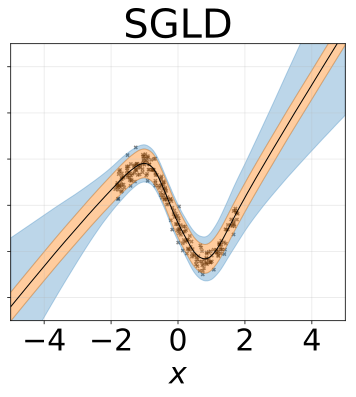

In [13]:
print("Using %d networks for prediction" % len(nets))
samples = []
noises = []
for network in nets:
    preds = network.forward(torch.linspace(-5, 5, 200).cuda()).cpu().data.numpy()
    samples.append(preds)
    noises.append(torch.exp(network.log_noise).cpu().data.numpy())
    
samples = np.array(samples)
noises = np.array(noises).reshape(-1)
means = (samples.mean(axis = 0)).reshape(-1)

aleatoric = noises.mean()
epistemic = (samples.var(axis = 0)**0.5).reshape(-1)
total_unc = (aleatoric**2 + epistemic**2)**0.5


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200), means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200), means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200), means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200), means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=30)
plt.title('SGLD', fontsize=40)
plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('sgld.pdf', bbox_inches = 'tight')

files.download("sgld.pdf")

plt.show()